In [1]:
import numpy as np
import cosmopower as cp
import matplotlib.pyplot as plt
import baccoemu as bacco
import MGrowth as mg
import copy
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_palette(sns.color_palette("Paired"))

from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})

plt.rc('mathtext', fontset='stix')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('font',size=20)
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('lines', linewidth=3)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=18)

# Load Karim's emulators

In [2]:
baccoemu = bacco.Matter_powerspectrum()
DS_nl_As = cp.cosmopower_NN(restore=True,
                          restore_filename='emulators/DS_nonlinear_cp_NN_lnAs',
                         )
DS_nl_S8 = cp.cosmopower_NN(restore=True,
                          restore_filename='emulators/DS_nonlinear_cp_NN_S8',
                         )
DS_lin_As = cp.cosmopower_NN(restore=True,
                          restore_filename='emulators/DS_linear_cp_NN_lnAs',
                         )
DS_lin_S8 = cp.cosmopower_NN(restore=True,
                          restore_filename='emulators/DS_linear_cp_NN_S8',
                         )
print(DS_nl_As.modes.shape, DS_nl_S8.modes.shape, DS_lin_As.modes.shape, DS_lin_As.modes.shape)
k_lin = DS_lin_As.modes
k_nonlin = DS_nl_As.modes

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/Users/s2265800/miniforge3/envs/mgl_ccl_cloe_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/s2265800/miniforge3/envs/mgl_ccl_cloe_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/s2265800/miniforge3/envs/mgl_ccl_cloe_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimat

Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


(360,) (360,) (372,) (372,)


In [3]:
def get_Pk_DS_S8(dic):
    Pk_nl_DS = DS_nl_S8.ten_to_predictions_np(dic)
    Pk_lin_DS = DS_lin_S8.ten_to_predictions_np(dic) 
    return Pk_lin_DS, Pk_nl_DS

def get_Pk_DS_As(dic):
    Pk_nl_DS = DS_nl_As.ten_to_predictions_np(dic)
    Pk_lin_DS = DS_lin_As.ten_to_predictions_np(dic)
    return Pk_lin_DS, Pk_nl_DS

def AstoS8_wACDM(dic, corr=False):
    # returns z-dependent S8: sigma8_ds(z)*sqtr(Omm/0.3)
    w0 = dic['w'][0]
    h = dic['h'][0]
    omega_b = dic['omega_b'][0]
    omega_cdm = dic['omega_cdm'][0]
    Ads = dic['A'][0]
    Omm = (omega_cdm+omega_b)/h**2
    Omb = omega_b/h**2
    As = dic['As'][0]
    params_bacco = {
            'ns'            :  dic['n_s'][0],
            'A_s'   :  As,
            'hubble'        :  h,
            'omega_baryon'  :  Omb,
            'omega_cold'    :  Omm,
            'neutrino_mass' :  dic['m_nu'][0],
            'w0'            :  -1.,
            'wa'            :  0.,
            'expfactor'     :  1.
        }
    # at z=0
    sigma_s8_GR = baccoemu.get_sigma8(**params_bacco)
    if w0 == -1.:
        xi = 0.   
    else:    
        xi=Ads/(1.+w0) 

    if corr:
        Rc = omega_cdm/h**2/Omm
        unit_conv = 0.0194407
        print('xi: ', xi)
        xi = xi*Rc/(1.+ unit_conv*h*(1.-Omm)*(1. + w0)*xi*(1.-Rc)) #ReACT parameters    
        print('xi corrected: ', xi)

    background ={'Omega_m': Omm,
            'h' : h,
            'w0': -1.,
            'wa': 0.,
            'a_arr': [1.]}
    background_DE ={'Omega_m': Omm,
            'h' : h,
            'w0': w0,
            'wa': 0.,
            'a_arr': [1./(1+dic['z'][0])]}
    cosmo1 = mg.IDE(background_DE)   
    Da, _ = cosmo1.growth_parameters(xi=xi) 
    cosmo0 = mg.LCDM(background)   
    Da_LCDM, _ = cosmo0.growth_parameters() 
    D_t = Da[0]/Da_LCDM[0]
    # at z
    sigma_s8 = sigma_s8_GR*D_t 
    return sigma_s8*np.sqrt(Omm/0.3)


     
def lingrowth(dic,  corr=False):
    # return Dds(z)/Dlcdm(z=0) 
    w0 = dic['w'][0]
    h = dic['h'][0]
    omega_b = dic['omega_b'][0]
    omega_cdm = dic['omega_cdm'][0]
    Ads = dic['A'][0]
    Omm = (omega_cdm+omega_b)/h**2
    zz = dic['z'][0]
    if w0==-1.:
        xi = 0.
    else:
        xi = Ads/(1.+w0)

    if corr:
        Rc = omega_cdm/h**2/Omm
        unit_conv = 0.0194407
        print('xi: ', xi)
        xi = xi*Rc/(1.+ unit_conv*h*(1.-Omm)*(1. + w0)*xi*(1.-Rc)) #ReACT parameters    
        print('xi corrected: ', xi)


    background ={'Omega_m': Omm,
            'h' : h,
            'w0': -1.,
            'wa': 0.,
            'a_arr': [1.]}
    background_DE ={'Omega_m': Omm,
            'h' : h,
            'w0': w0,
            'wa': 0.,
            'a_arr': [1./(1.+zz)]}
    cosmo1 = mg.IDE(background_DE)   
    D_g, _ = cosmo1.growth_parameters(xi=xi) 
    cosmo0 = mg.LCDM(background)   
    D_norm_lcdm, _ = cosmo0.growth_parameters() 
    D_t = D_g/D_norm_lcdm

    return D_t

def bacco_lin(dic, k):
    w = dic['w']
    h = dic['h']
    omega_b = dic['omega_b']
    omega_cdm = dic['omega_cdm']
    Omm = (omega_cdm+omega_b)/h**2
    Omb = omega_b/h**2
    aa = 1./(1.+dic['z'])
    if 'As' in dic:
        As = dic['As']
        params_bacco = {
                'ns'            :  dic['n_s'],
                'A_s'   :  As,
                'hubble'        :  h,
                'omega_baryon'  :  Omb,
                'omega_cold'    :  Omm,
                'neutrino_mass' :  dic['m_nu'],
                'w0'            :  w,
                'wa'            :  0.,
                'expfactor'     :  aa
            }
    elif 'S_8' in dic:
        sigma8 = dic['S_8']/np.sqrt(Omm/0.3)
        params_bacco = {
                'ns'            :  dic['n_s'],
                'sigma8_cold'   :  sigma8,
                'hubble'        :  h,
                'omega_baryon'  :  Omb,
                'omega_cold'    :  Omm,
                'neutrino_mass' :  dic['m_nu'],
                'w0'            :  w,
                'wa'            :  0.,
                'expfactor'     :  aa
            }    
    return baccoemu.get_linear_pk(k=k, cold=False, **params_bacco)



In [4]:
#fiducial values
lnAs_fid = 3.044 #2.9 #3.044
As_fid = np.exp(lnAs_fid)*1e-10
ns = 0.97
z = 0.
Om_m = 0.31
h = 0.68
omega_b = 0.02242
omega_cdm = Om_m*h**2-omega_b
Om_b = omega_b/h**2
Om_cdm = Om_m - Om_b
m_nu = 0.

def prepare_dic(dic):
    w = dic['w']
    Ads = dic['Ads']
    zz = dic['zz']
    if 'S8' in dic:
        S8 = dic['S8']
        params_ds = {'omega_b': omega_b*np.ones(1),
                    'omega_cdm': omega_cdm*np.ones(1),
                    'h': h*np.ones(1),
                    'n_s': ns*np.ones(1),
                    'S_8': S8*np.ones(1),
                    'm_nu': m_nu*np.ones(1),
                    'w': w*np.ones(1),
                    'A': Ads*np.ones(1),
                    'z': zz*np.ones(1)
                    }
    elif 'As' in dic and 'lnAs' in dic:
        params_ds = {'omega_b': omega_b*np.ones(1),
                'omega_cdm': omega_cdm*np.ones(1),
                'h': h*np.ones(1),
                'n_s': ns*np.ones(1),
                'ln10^{10}A_s': dic['lnAs']*np.ones(1),
                'As': dic['As']*np.ones(1),
                'm_nu': m_nu*np.ones(1),
                'w': w*np.ones(1),
                'A': Ads*np.ones(1),
                'z': zz*np.ones(1)
                }
    else:
        raise ValueError('Some parameters are missing from the dic with varying params!')
    return params_ds

In [5]:
#zmax=2.4 for ReACT
z = np.linspace(0., 2.3, 5)
fid_dic = { 'w': -1., 'Ads': 0., 'As': As_fid, 'lnAs': lnAs_fid, 'zz': 0.}
lcdm_fid_dic = prepare_dic(fid_dic)
S8_fid = AstoS8_wACDM(lcdm_fid_dic) #at z=0
#lcdm
S8_lcdm = []
bacco_lin_as = []
dsemu_lcdm_lin_as = []
bacco_lin_s8 = []

dsemu_lcdm_lin_s8 = []
for z_i in z:
    vary_dic = { 'w': -1., 'Ads': 0., 'As': As_fid, 'lnAs': lnAs_fid, 'zz': z_i}
    lcdm_dic = prepare_dic(vary_dic)
    S8_lcdm.append(AstoS8_wACDM(lcdm_dic))
    bacco_lin_as.append(bacco_lin(lcdm_dic, k_lin)[1])
    dsemu_lcdm_lin_as.append(get_Pk_DS_As(lcdm_dic)[0][0])
    
    vary_dic_s8 = { 'w': -1., 'Ads': 0., 'S8': S8_fid, 'zz': z_i}
    lcdm_dic_s8 = prepare_dic(vary_dic_s8)
    dsemu_lcdm_lin_s8.append(get_Pk_DS_S8(lcdm_dic_s8)[0][0])

In [6]:
#suppression for w0>-1 and Ads>0
S8_sup = []
S8_sup_corr = []
dsemu_as_lin_asfid = []
dsemu_s8_lin_asfid = []
lin_growth_norm_lcdmz0 = []
lin_growth_norm_lcdmz0_corrxi = []
### PICK YOUR VALUES OF DS PARAMETERS HERE ###
w0 = -0.8
Ads = 20.
##############################################
for i in range(len(z)):
    vary_dic = { 'w': w0, 'Ads': Ads, 'As': As_fid, 'lnAs': lnAs_fid, 'zz': z[i]}
    dsemu_dic = prepare_dic(vary_dic)
    S8_sup.append(AstoS8_wACDM(dsemu_dic))
    S8_sup_corr.append(AstoS8_wACDM(dsemu_dic, corr=True))
    dsemu_as_lin_asfid.append(get_Pk_DS_As(dsemu_dic)[0][0])
    lin_growth_norm_lcdmz0.append(lingrowth(dsemu_dic))
    lin_growth_norm_lcdmz0_corrxi.append(lingrowth(dsemu_dic, corr=True))

    vary_dic_s8 = { 'w': w0, 'Ads': Ads, 'S8': S8_sup_corr[0], 'zz': z[i]}
    dsemu_dic_s8 = prepare_dic(vary_dic_s8)
    dsemu_s8_lin_asfid.append(get_Pk_DS_S8(dsemu_dic_s8)[0][0])

xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383
xi:  100.00000000000003
xi corrected:  82.01900903461383


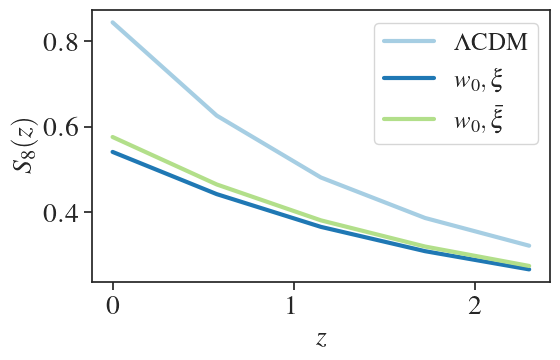

In [7]:
fig, ax = plt.subplots(1,figsize=(6, 4), sharex = False, sharey= True)
#ax.set_ylabel(r"$P^{\Lambda \rm CDM}_{\rm DSemu}/P^{\Lambda \rm CDM}_{\rm bacco}$",fontsize=20)
ax.set_ylabel(r"$S_8(z)$",fontsize=20)
ax.plot(z, S8_lcdm, label=r'$\Lambda \rm CDM$')
ax.plot(z, S8_sup, label=r'$w_0, \xi$')
ax.plot(z, S8_sup_corr, label=r'$w_0, \bar{\xi}$')
ax.set_xlabel(r"$z$",fontsize=20)
ax.legend(loc='best')
plt.tight_layout()

# Matching linear power spectrum emulators

DS_linear_cp_NN_lnAs emulator is trained with two extended DS parameters $A_{\rm ds}$ and $w_0$ with the following mapping: 

* $A_{\rm ds}=\xi/(1+w_0) \rightarrow \bar{\xi}=\frac{\xi R_c}{1+0.0194407 h (1-\Omega_{\rm m})(1+w_0) \xi (1-R_c)}$ with $R_c=\Omega_{\rm cdm}/\Omega_{\rm m}$. 

So that the scale-independent linear growth corresponds to the solution of the linearised growth equation with $w_0$ and $\bar{\xi}$.

DS_linear_cp_NN_S8 emulator is also trained with two extended DS parameters $A_{\rm ds}$ and $w_0$. Now, to match the predictions between the two emulators for the linear power spectrum with the linear growth from $w_0$ and $\bar{\xi}(\xi=A_{\rm ds}/(1+w_0), \Omega_{\rm m}, \Omega_{\rm cdm}, h)$, one should follow these steps

* pick a value in $A_s$, $w_0$ and $A_{\rm ds}$ and other cosmological parameters 
* compute $\sigma_8$ in GR using bacco or HMcode emulators for $A_s$+cosmo+$w_0=-1, A_{\rm ds}=0$
* compute the linear growth factor in DS and re-scale: $\sigma_8^{\rm DS}=\sigma_8^{\rm GR} \frac{D_{\rm DS}(z=0, w_0, \bar{\xi})}{D_{\rm GR}(z=0)}$   
* $S_8^{\rm DS} = \sigma_8^{\rm DS} \sqrt{\Omega_{\rm m}/0.3}$

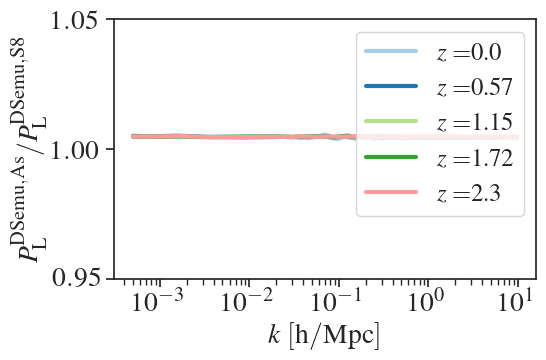

In [8]:
fig, ax = plt.subplots(1,figsize=(6, 4), sharex = False, sharey= True)
ax.set_ylabel(r"$P_{\rm L}^{\rm DSemu, As}/P_{\rm L}^{\rm DSemu, S8}$",fontsize=20)
for i in range(len(z)):
    ax.semilogx(k_lin, (dsemu_as_lin_asfid[i]/dsemu_s8_lin_asfid[i]),  linestyle='-', label='$z=$'+str(round(z[i], 2)))
ax.set_xlabel(r"$k \ \mathrm{[h/Mpc]}$",fontsize=20)
ax.legend(loc='upper right', frameon=True)
ax.set_ylim(0.95, 1.05)
plt.tight_layout()

(372,)
(372,)


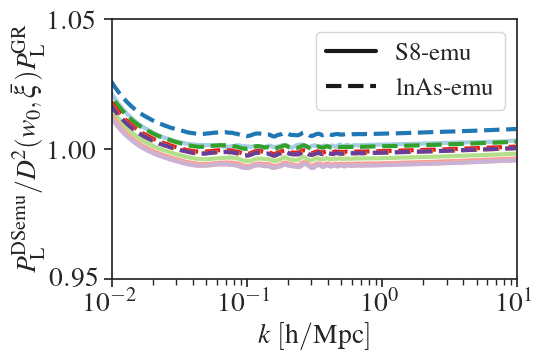

In [9]:
fig, ax = plt.subplots(1,figsize=(6, 4), sharex = False, sharey= True)
ax.set_ylabel(r"$P_{\rm L}^{\rm DSemu}/D^2(w_0, \bar{\xi})P_{\rm L}^{\rm GR}$",fontsize=20)
print(bacco_lin_as[0].shape)
print(dsemu_s8_lin_asfid[0].shape)
for i in range(len(z)):
    ax.semilogx(k_lin, (dsemu_s8_lin_asfid[i]/(lin_growth_norm_lcdmz0_corrxi[i]**2*bacco_lin_as[0])),  linestyle='-')
    ax.semilogx(k_lin, (dsemu_as_lin_asfid[i]/(lin_growth_norm_lcdmz0_corrxi[i]**2*bacco_lin_as[0])),  linestyle='--')
ax.axhline(0.9, color='k', linestyle='-', label='S8-emu')
ax.axhline(0.9, color='k', linestyle='--', label='lnAs-emu')
ax.set_xlabel(r"$k \ \mathrm{[h/Mpc]}$",fontsize=20)
ax.legend(loc='upper right', frameon=True)
# restrict k>0.01 because of the super-horizon effects in dark energy scenarios which are not captured by the re-scaling of the linear power psectrum in GR wiht the modified growth factor
ax.set_xlim(0.01, 10.)
ax.set_ylim(0.95, 1.05)
plt.tight_layout()

# Matching nonlinear power spectrum emulators

In [10]:
dsemu_as_nonlin_asfid = []
dsemu_s8_nonlin_asfid = []

for i in range(len(z)):
    vary_dic = { 'w': w0, 'Ads': Ads, 'As': As_fid, 'lnAs': lnAs_fid, 'zz': z[i]}
    dsemu_dic = prepare_dic(vary_dic)
    dsemu_as_nonlin_asfid.append(get_Pk_DS_As(dsemu_dic)[1][0])

    vary_dic_s8 = { 'w': w0, 'Ads': Ads, 'S8': S8_sup_corr[0], 'zz': z[i]}
    dsemu_dic_s8 = prepare_dic(vary_dic_s8)
    dsemu_s8_nonlin_asfid.append(get_Pk_DS_S8(dsemu_dic_s8)[1][0])

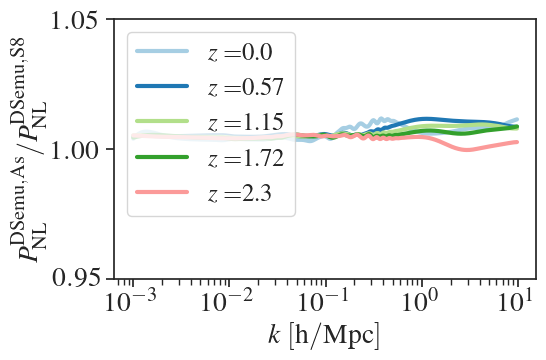

In [11]:
fig, ax = plt.subplots(1,figsize=(6, 4), sharex = False, sharey= True)
ax.set_ylabel(r"$P_{\rm NL}^{\rm DSemu, As}/P_{\rm NL}^{\rm DSemu, S8}$",fontsize=20)
for i in range(len(z)):
    ax.semilogx(k_nonlin, (dsemu_as_nonlin_asfid[i]/dsemu_s8_nonlin_asfid[i]),  linestyle='-', label='$z=$'+str(round(z[i], 2)))
ax.set_xlabel(r"$k \ \mathrm{[h/Mpc]}$",fontsize=20)
ax.legend(loc='upper left', frameon=True)
ax.set_ylim(0.95, 1.05)
plt.tight_layout()

# Matching the boost $B = P^{\rm DS}_{\rm NL}/P^{\rm GR}_{\rm NL}$

In other words what is the equivalent of GR in DSemu-emulators? We use HMcode2020 for the nonlinear predictions in GR.